<center> <h1> Neural Networks for Image Classification </h1> </center>


In this homework we will train convolutional neural network image dataset of with ten classes. We will follow the best practices of training and split our dataset into three parts: training set, validation set and test set. We will experiment with the neural network architecture, training parameters like learning rate, learning rate scheduling, batch size, image augmentations, number of epochs of training.

<center> <h2> Cifar-10 dataset </h2> </center>

For our experiments we will use a subset of [Cifar-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) which contains images of ten diverse classes of objects.



![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png "Logo Title Text 1")


<center> <h2> Kaggle Competition Registration and Submission </h2> </center>

1. Follow this link and create account on kaggle and register for the compeition:
https://www.kaggle.com/t/73bf90acaef64d5db91d5e74028270c7
2. During training of your network a ```csv``` file with your predictions on the test set is being saved. You can find it and download it if you press on the folder icon on the left of your page.
3. Once your model is fully trained and you are satisfied with your results on the validation dataset, download this file and upload your submission to kaggle and it will evaluate your results on the test set. Your submission will be ranked amond all classmates.


In [ ]:
# Run this to install a dependency
!pip install livelossplot==0.3.4

In [ ]:
!pip install ipython-autotime
%load_ext autotime 

time: 162 µs (started: 2022-05-10 20:03:26 +00:00)


In [ ]:
!pip install pytorchtools

time: 2.93 s (started: 2022-05-10 20:03:26 +00:00)


# Main Function

In [ ]:
import torch

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import numpy as np

from torch.utils.data import Subset

import torch.nn as nn
import torch.nn.functional as F

# Our simple convolutional neural network which can allow you to get a
# decent accuracy. It consists of a convolutional layers, pooling layer
# and fully connected layer (nn.Linear).
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=48, kernel_size=3, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(192),
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=192, out_channels=320, kernel_size=3, padding=1),
            nn.BatchNorm2d(320),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=320, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8192, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )



    def forward(self, x):
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

# Here we define transformation that we will apply to our images
# during training. So far we have a random crop, horizontal flip and normalization.
# Normalization is not an augmentation but a common practice when working with images,
# we are subtracting the average RGB pixel value from each pixel of image and dividing by
# the standart deviation of RGB value in the dataset.
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Batch size can be set here.
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=256,
                                          shuffle=True,
                                          num_workers=4,
                                          drop_last=True)

test_and_val_set = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform_test)

# Splitting our dataset into valset and test set.
# Valset will be used to monitor our accuracy during training and test set
# will be used to submit your final results to kaggle. It is common for machine
# learning to split dataset into train/val/test and is considered a best practice.
indices = np.arange(len(test_and_val_set))
val_set = Subset(test_and_val_set, indices[:5000])
test_set = Subset(test_and_val_set, indices[5000:])

val_set_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)
test_set_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, num_workers=2)

# Here we define our loss function which is cross entropy -- a common loss function when
# working with classification problems.
criterion = nn.CrossEntropyLoss().cuda()

# Here we are defining our network, putting it on GPU and set it up into a training mode.
# Training mode is needed when some special layers are used like Batch normalization or dropout,
# since they have different behaviour during training and evaluation of our network.
net = CNN()
net = net.cuda()
net.train()

# Here we define our optimizer and learning rate. Other optimizers can be used like Adam
# and you can experiment with them -- although you will have to carefully choose learning rate
# in that case.
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

# Below we define a validation function which will be run after each epoch to
# see if accuracy of our model improved or worsened.
def validate():
    
    net.eval()
    
    counter = 0
    correctly_predicted_counter = 0

    with torch.no_grad():

        for batch_idx, (inputs, targets) in enumerate(val_set_loader):

            inputs, targets = inputs.cuda(), targets.cuda()

            outputs = net(inputs)
            _, predicted_classes = outputs.max(1)

            counter += targets.size(0)
            correctly_predicted_counter += (predicted_classes == targets).sum().item()
    
    accuracy = float(correctly_predicted_counter) / counter
    
    predicted_classes_list = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_set_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            _, predicted_classes = outputs.max(1)
            predicted_classes_list += list(map(lambda x: str(x), predicted_classes.cpu().detach().numpy().tolist()))

    predicted_classes_list = list(enumerate(predicted_classes_list))
    
    net.train()
    
    return accuracy, predicted_classes_list

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


In [ ]:
# If you just put a variable containing your model in a cell and run it
# it will output your network structure. Useful for debugging.
net

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

# Output results

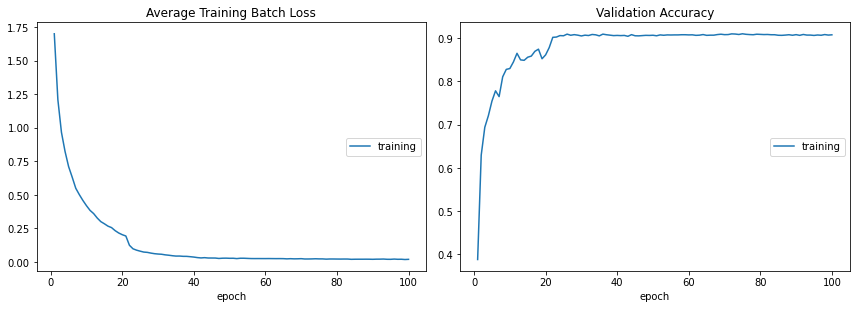

Average Training Batch Loss:
training   (min:    0.018, max:    1.700, cur:    0.019)

Validation Accuracy:
training   (min:    0.388, max:    0.910, cur:    0.908)
2829.655271053314


In [ ]:
%matplotlib inline

from livelossplot import PlotLosses

liveloss = PlotLosses()

import time
import pandas as pd

best_accuracy = 0.0

start = time.time()


for epoch_number in range(100):
    
    train_loss_list = []

    for batch_idx, (inputs, targets) in enumerate(trainloader):

        inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss_list.append(loss.data.item())
    
    if epoch_number == 20:

        for param_group in optimizer.param_groups:

            param_group['lr'] = 0.01

    if epoch_number == 40: 

        for param_group in optimizer.param_groups:

            param_group['lr'] = 0.001

           
        
    current_accuracy, predicted_classes_list = validate()

    liveloss.update({'Average Training Batch Loss': sum(train_loss_list) / len(train_loss_list),
                     'Validation Accuracy': current_accuracy})
    liveloss.draw()

    if current_accuracy > best_accuracy:

        print(current_accuracy)
        best_accuracy = current_accuracy
        torch.save(net.state_dict(), 'resnet_20_cifar10_kaggle.pth')
        # Saving best predictions so far
        submission_df = pd.DataFrame(predicted_classes_list, columns = ['Id', 'Category'])
        submission_df = submission_df['Category']
        submission_df = submission_df.replace(0)
        submission_df = pd.DataFrame(submission_df)
        submission_df['Id'] = submission_df.index
        submission_df = submission_df[['Id', 'Category']]
        submission_df.to_csv('cifar_10_best_submission.csv', index=False)
        
end = time.time()
print(end - start)

# Below you can observe drop in the training loss at some point and increase in the validation accuracy.
# This is the place where we decreased the learning rate.

In [ ]:
best_accuracy

0.9104

#### Kaggle Competition

To submit your results to Kaggle:

1. Create a kaggle account.
2. Follow the  [link](https://www.kaggle.com/t/73bf90acaef64d5db91d5e74028270c7) to join the competion.
3. After your code completes, press on the "files" button and download ```cifar_10_best_submission.csv``` file and upload it to kaggle to evaluate it on the test dataset.


#### Additional experiments

To improve your model further try to:

1. Increase the number of filters.
2. Increate the number of layers.
3. Choose different architecture, for example a deep residual network:
https://arxiv.org/pdf/1512.03385.pdf
4. Top three submissions will present their solutions to the class and will potentially get bonus points.